# Zależności

In [264]:
import pandas as pd
import nltk
import unicodedata
import re
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import gensim
from gensim.models import Word2Vec

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Michał\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Michał\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Michał\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# Załadowanie danych

In [5]:
tweets_biden = pd.read_csv('../data/US Election 2020 Tweets/hashtag_joebiden.csv', lineterminator='\n', parse_dates=True)
tweets_trump = pd.read_csv('../data/US Election 2020 Tweets/hashtag_donaldtrump.csv', lineterminator='\n', parse_dates=True) 

In [6]:
tweets_biden.head()

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,...,1860.0,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00
1,2020-10-15 00:00:18,1.316529e+18,#HunterBiden #HunterBidenEmails #JoeBiden #Joe...,0.0,0.0,Twitter for iPad,8.099044e+08,Cheri A. 🇺🇸,Biloximeemaw,"Locked and loaded Meemaw. Love God, my family ...",...,6628.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.517827283
2,2020-10-15 00:00:20,1.316529e+18,@IslandGirlPRV @BradBeauregardJ @MeidasTouch T...,0.0,0.0,Twitter Web App,3.494182e+09,Flag Waver,Flag_Wavers,NaN,...,1536.0,Golden Valley Arizona,46.304036,-109.171431,NaN,United States of America,North America,Montana,MT,2020-10-21 00:00:01.035654566
3,2020-10-15 00:00:21,1.316529e+18,@chrislongview Watching and setting dvr. Let’s...,0.0,0.0,Twitter for iPhone,8.242596e+17,Michelle Ferg,MichelleFerg4,NaN,...,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:01.553481849
4,2020-10-15 00:00:22,1.316529e+18,#censorship #HunterBiden #Biden #BidenEmails #...,1.0,0.0,Twitter Web App,1.032807e+18,the Gold State,theegoldstate,A Silicon Valley #independent #News #Media #St...,...,390.0,"California, USA",36.701463,-118.755997,NaN,United States of America,North America,California,CA,2020-10-21 00:00:02.071309132


# Czyszczenie danych

Tweety tylko z USA

In [7]:
text_biden = tweets_biden.loc[tweets_biden['country'] == 'United States of America']['tweet']
text_trump = tweets_trump.loc[tweets_trump['country'] == 'United States of America']['tweet']

Przycinanie dat (w celu późniejszej agregacji)

In [12]:
def reduce_date_to_day(date):
    return date[:10]

In [216]:
lemmatizer = WordNetLemmatizer()

def clean_tweet(text):
    stopwords = nltk.corpus.stopwords.words('english')
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore').lower()
    text = re.sub(r'#[^ ]+', '', text)  # removing hashtags
    text = re.sub(r'https.+', '', text)  # removing links
    text = re.sub(r'@[^ ]+', '', text)  # removing mentions
    text = re.sub(r'[^(a-zA-Z)\s]', '', text) # removing special characters

    words = text.split() 
    filtered_words = [word for word in words if word not in stopwords] 
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]
    # lemmatized_words = words
    
    return " ".join(lemmatized_words)

In [217]:
tweets_biden['cleaned_tweet'] = tweets_biden['tweet'].apply(clean_tweet)
tweets_trump['cleaned_tweet'] = tweets_trump['tweet'].apply(clean_tweet)

Prezentacja działania

In [218]:
from pandas import option_context
from IPython.display import display, HTML

pd.set_option('display.width', 2000)

with option_context('display.max_colwidth', 120):
    display(tweets_biden[['tweet', 'cleaned_tweet']])
    # print(tweets_biden[['cleaned_tweet']])


,tweet,cleaned_tweet
0,#Elecciones2020 | En #Florida: #JoeBiden dice que #DonaldTrump solo se preocupa por él mismo. El demócrata fue anfit...,en dice que solo se preocupa por el mismo el democrata fue anfitrion de encuentros de electores en y clic aqui
1,#HunterBiden #HunterBidenEmails #JoeBiden #JoeBidenMustStepDown https://t.co/9enmxWvePm,
2,@IslandGirlPRV @BradBeauregardJ @MeidasTouch This is how #Biden made his ! #TrumpIsNotAmerica !\nhttps://t.co/uBqAFU...,this is how made his
3,@chrislongview Watching and setting dvr. Let’s give him bonus ratings!! #JoeBiden,watching and setting dvr lets give him bonus ratings
4,#censorship #HunterBiden #Biden #BidenEmails #BidenEmail #Corruption https://t.co/C6clrtshQl,
...,...,...
499823,Votes get “whittled down”? Counting of mail in ballots while his numbers stayed the same #biden votes went up. #Tr...,votes get whittled down counting of mail in ballots while his numbers stayed the same votes went up
499824,CONTINÚAN SALIENDO LAS PRUEBAS DEL FRAUDE ELECTORAL QUE #Biden ESTÁ EJECUTANDO!! 👇👇@unitedpress @europapress @bbcm...,continuan saliendo las pruebas del fraude electoral que esta ejecutando el castro chavismo en pueblo
499825,#ElectionResults2020 #USElection #ThursdayThoughts #TrumpMeltdown #TrumpvsBiden #CountAllLegalVotes #ByeByeTrump #Bi...,
499826,I wonder who they’re voting for 🤔... - #fyp #foryou #foryoupage #beverlyhills #90210 #rodeo #rodeodrive #donaldtrump...,i wonder who theyre voting for rodeo dr beverly hills ca


In [206]:
tweets_biden['date'] = tweets_biden['created_at'].apply(reduce_date_to_day)
tweets_trump['date'] = tweets_trump['created_at'].apply(reduce_date_to_day)

# Wyznaczanie sentymentu za pomocą VADER

In [172]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

def sentimentWithVADER(text):
    return sid.polarity_scores(text)['compound']

Wyliczenie sentymentu

In [11]:
tweets_biden['VADER']=tweets_biden['tweet'].apply(sentimentWithVADER) 
tweets_trump['VADER']=tweets_trump['tweet'].apply(sentimentWithVADER)

In [143]:
vader_biden_sentiment = tweets_biden[['VADER', 'date']].groupby(['date']).mean()
vader_trump_sentiment = tweets_trump[['VADER', 'date']].groupby(['date']).mean()

<Axes: xlabel='date'>

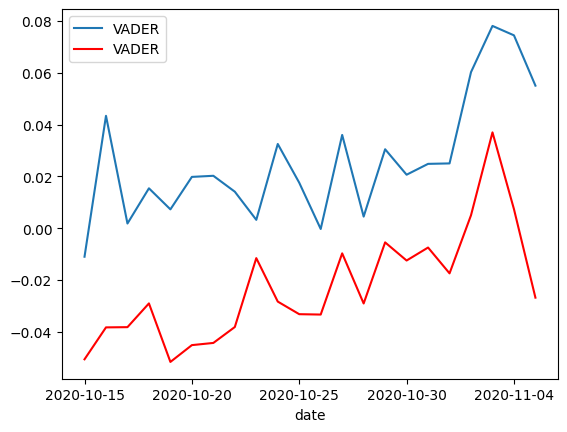

In [154]:
ax = vader_biden_sentiment.plot()
vader_trump_sentiment.plot(ax=ax, color="red")

In [147]:
def plot_sentiment(biden_sentiment, trump_sentiment):
    sunday_indices = list(range(3, 22, 7))
    plot_options = {
        "figsize": (12,6),
        "xlim": (0,21)
    }
    
    ax = biden_sentiment.plot(**plot_options)
    trump_sentiment.plot(ax=ax, color="red")
    ax.legend(["Biden", "Trump"])
    ax.set_xticks(sunday_indices)
    ax.set_xticklabels(biden_sentiment.index[sunday_indices], rotation=-45, ha="left")
    ax.set_xticks(list(range(0,22,1)), minor=True)
    ax.set_xticklabels(biden_sentiment.index, minor=True, rotation=-45, ha="left")
    ax.set_xlabel("Data")
    # ax.set_title("Średni sentyment dla obu kandydatów mierzony wyznaczany za pomocą algorytmu VADER")
    ax.grid(which='both')
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    plt.axvspan(19, 22, color='grey', alpha=0.2)
    return ax

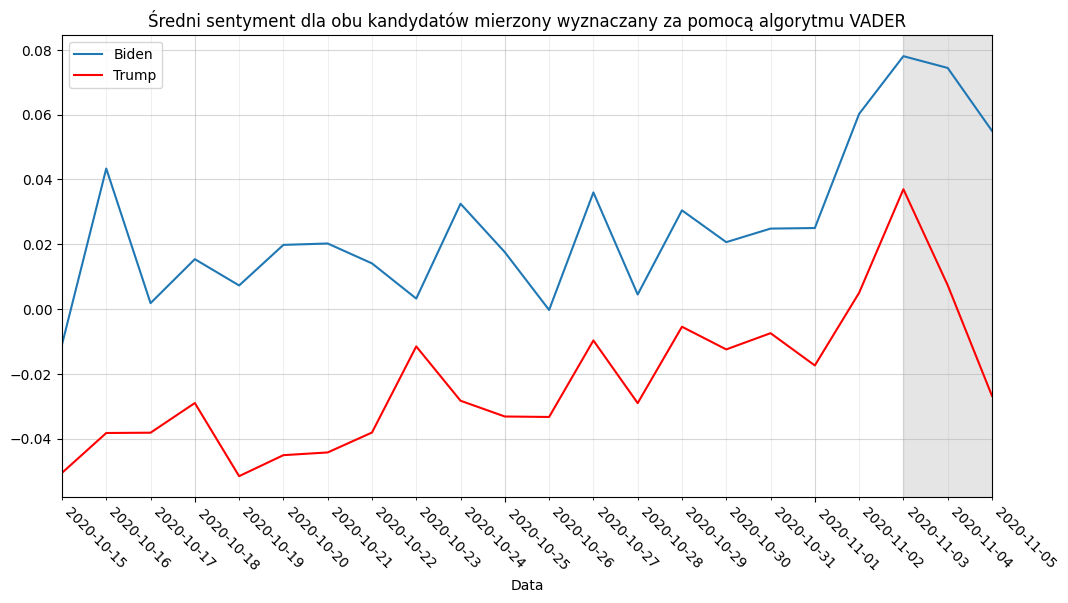

In [148]:
ax = plot_sentiment(vader_biden_sentiment, vader_trump_sentiment)
ax.set_title("Średni sentyment dla obu kandydatów mierzony wyznaczany za pomocą algorytmu VADER")
plt.savefig("../images/vader.png")

# Wyznaczanie sentymentu za pomocą TextBlob 

https://towardsdatascience.com/my-absolute-go-to-for-sentiment-analysis-textblob-3ac3a11d524

In [176]:
def sentimentWithTextBlob(text):
    return TextBlob(text).sentiment.polarity

In [177]:
tweets_biden['TextBlob']=tweets_biden['tweet'].apply(sentimentWithTextBlob) 
tweets_trump['TextBlob']=tweets_trump['tweet'].apply(sentimentWithTextBlob)

In [178]:
textblob_biden_sentiment = tweets_biden[['TextBlob', 'date']].groupby(['date']).mean()
textblob_trump_sentiment = tweets_trump[['TextBlob', 'date']].groupby(['date']).mean()

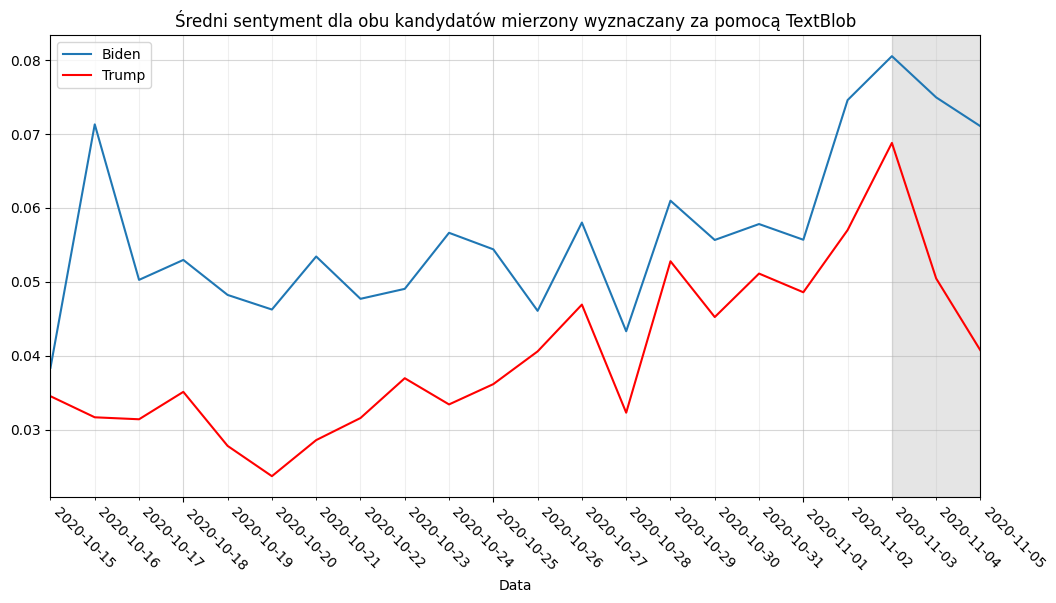

In [179]:
ax = plot_sentiment(textblob_biden_sentiment, textblob_trump_sentiment)
ax.set_title("Średni sentyment dla obu kandydatów mierzony wyznaczany za pomocą TextBlob")
plt.savefig("../images/textblob.png")

# Wyznaczanie sentymentu Word2Vec

#https://www.kaggle.com/code/nitin194/twitter-sentiment-analysis-word2vec-doc2vec

In [241]:
biden_tokenized_tweets = tweets_biden['cleaned_tweet'].apply(lambda x: x.split())
trump_tokenized_tweets = tweets_trump['cleaned_tweet'].apply(lambda x: x.split())

tokenized_tweets = pd.concat([biden_tokenized_tweets, trump_tokenized_tweets])
tokenized_tweets

0         [en, dice, que, solo, se, preocupa, por, el, m...
1                                                        []
2                                [this, is, how, made, his]
3         [watching, and, setting, dvr, lets, give, him,...
4                                                        []
                                ...                        
725649                                                 [by]
725650    [did, you, ever, speak, to, someone, on, publi...
725651    [so, they, accepted, ballots, way, more, than,...
725652    [zegt, nu, gewoon, if, you, only, count, my, v...
725653                 [speech, truthometer, as, we, speak]
Name: cleaned_tweet, dtype: object

In [255]:
vec_size = 100

In [242]:
w2v_model = gensim.models.Word2Vec(
            tokenized_tweets,
            vector_size=vec_size,
            window=5, # context window size
            min_count=1, # Ignores all words with total frequency lower than 1.                                  
            workers= 32, # no.of cores
) 


In [262]:
model_path = "../models/word2vec.model"
w2v_model.save("../models/word2vec.model")

In [265]:
w2v_model = Word2Vec.load(model_path)

In [266]:
def text_to_vector(text):
    tokens = text.split()
    vec = np.zeros(vec_size).reshape((1, vec_size))
    count = 0
    for word in tokens:
        try:
            vec += w2v_model.wv[word].reshape((1, vec_size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec

In [267]:
tweets_biden["cleaned_tweet"].apply(text_to_vector)

0         [[0.5751213080504731, -0.4006471493325773, 1.2...
1         [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
2         [[-1.313224685192108, -0.7931712031364441, -1....
3         [[-0.6575915101501677, 0.13275412056181166, -1...
4         [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
                                ...                        
499823    [[-0.6592904436919425, 0.7519082076226672, -0....
499824    [[0.325986125258108, -0.3590495027756939, 0.60...
499825    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
499826    [[-0.32442864978855307, 1.046495634046468, -0....
499827    [[-0.12862984468229116, 0.5118022305890918, -1...
Name: cleaned_tweet, dtype: object

# Wyznaczanie sentymentu za pomocą KE-MLM
https://github.com/GU-DataLab/stance-detection-KE-MLM

In [157]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np

In [158]:
def probability_to_sentiment(predicted_probability):
    return predicted_probability[1]-predicted_probability[0]

In [159]:
biden_pretrained_LM_path = "kornosk/bert-election2020-twitter-stance-biden-KE-MLM"

# load model
tokenizer_biden = AutoTokenizer.from_pretrained(pretrained_LM_path)
model_biden = AutoModelForSequenceClassification.from_pretrained(pretrained_LM_path)

def bidenSentimentWithKEMLM(text):
    inputs = tokenizer_biden(text, return_tensors="pt")
    outputs = model_biden(**inputs)
    predicted_probability = torch.softmax(outputs[0], dim=1)[0].tolist()
    return probability_to_sentiment(predicted_probability)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [167]:
trump_pretrained_LM_path = "kornosk/bert-election2020-twitter-stance-trump-KE-MLM"

# load model
tokenizer_trump = AutoTokenizer.from_pretrained(trump_pretrained_LM_path)
model_trump = AutoModelForSequenceClassification.from_pretrained(trump_pretrained_LM_path)

def trumpSentimentWithKEMLM(text):
    inputs = tokenizer_trump(text, return_tensors="pt")
    outputs = model_trump(**inputs)
    predicted_probability = torch.softmax(outputs[0], dim=1)[0].tolist()
    return probability_to_sentiment(predicted_probability)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [163]:
tweets_biden_sampled = tweets_biden.sample(frac=0.001)
tweets_trump_sampled = tweets_trump.sample(frac=0.001)

In [162]:
tweets_biden_sampled['KE-MLM']=tweets_biden_sampled['tweet'].apply(bidenSentimentWithKEMLM) 
tweets_biden_sampled.to_csv("biden_KE_MLM.csv")

KeyboardInterrupt: 

In [ ]:
tweets_trump_sampled['KE-MLM']=tweets_trump_sampled['tweet'].apply(trumpSentimentWithKEMLM)
tweets_trump_sampled.to_csv("trump_KE_MLM.csv")

In [ ]:
loaded_biden_tweets = pd.read_csv("biden_KE_MLM.csv")
loaded_trump_tweets = pd.read_csv("trump_KE_MLM.csv")

In [149]:
kemlm_biden_sentiment = loaded_biden_tweets[['KE-MLM', 'date']].groupby(['date']).mean()
kemlm_trump_sentiment = loaded_trump_tweets[['KE-MLM', 'date']].groupby(['date']).mean()

<Axes: xlabel='date'>

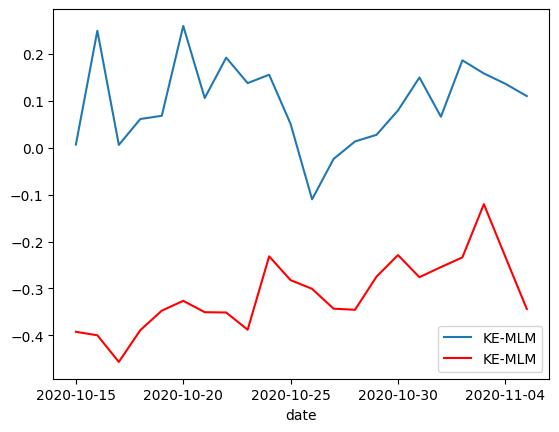

In [153]:
ax = kemlm_biden_sentiment.plot()
kemlm_trump_sentiment.plot(ax=ax, color="red")

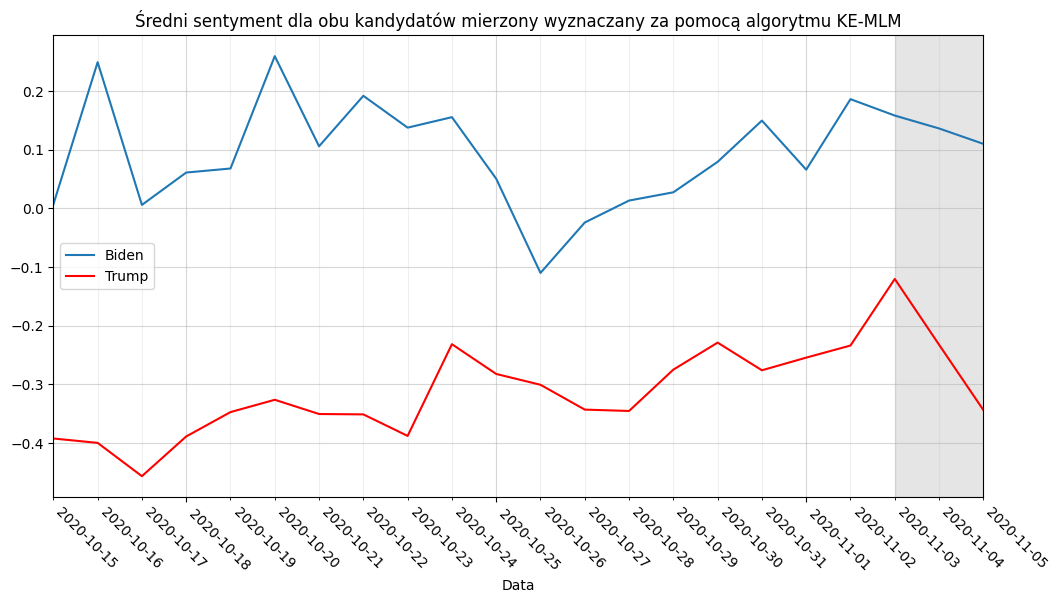

In [156]:
ax = plot_sentiment(kemlm_biden_sentiment, kemlm_trump_sentiment)
ax.set_title("Średni sentyment dla obu kandydatów mierzony wyznaczany za pomocą algorytmu KE-MLM")
plt.savefig("../images/ke-mlm.png")